# Analysis of artificial data using support vector machines (SVMs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

In [10]:
def generate_data(n_samples=1000, n_features=4, noise_std=2,
                  mean_a=None, mean_b=None, cov=None, seed=None):
    '''
        Generate synthetic binary classification data.
    '''
    if seed is not None:
        np.random.seed(seed)

    if mean_a is None:
        mean_a = [0] * n_features
    if mean_b is None:
        mean_b = [1, 4, 7, 0][:n_features]
    if cov is None:
        cov = np.array([
            [3, -3, -1, 0],
            [-3, 4, 1, 1],
            [-1, 1, 8, 1],
            [0, 1, 1, 6]
        ])
    cov = cov[:n_features, :n_features]

    noise_a = np.random.normal(0, noise_std, size=(n_samples, n_features))
    noise_b = np.random.normal(0, noise_std, size=(n_samples, n_features))

    data_a = np.random.multivariate_normal(mean_a, cov, n_samples) + noise_a
    data_b = np.random.multivariate_normal(mean_b, cov, n_samples) + noise_b

    data = np.vstack((data_a, data_b))
    labels = np.vstack((np.ones((n_samples, 1)), -np.ones((n_samples, 1))))

    return data, labels, data_a, data_b

In [11]:
def plot_data(class_a, class_b, dims=(0, 1), title="Synthetic Data", fname='data.pdf'):
    '''
        Plot data of two classes in specified dimensions.
    '''
    dim_x, dim_y = dims
    plt.figure()
    plt.plot(class_a[:, dim_x], class_a[:, dim_y], 'r.', label='Class A')
    plt.plot(class_b[:, dim_x], class_b[:, dim_y], 'b.', label='Class B')
    plt.axis('equal')
    plt.title(title)
    plt.xlabel(f"Dim {dim_x + 1}")
    plt.ylabel(f"Dim {dim_y + 1}")
    plt.legend()
    plt.grid(True)
    plt.savefig(fname)
    plt.show()

In [12]:
'''
    Exhaustive search (all possible combinations of features.)
'''

def generate_indicators(n_features):
    '''
        generates binary indicator vectors for all feature combinations.
    '''
    n_comb = 2 ** n_features
    indicators = np.array([list(map(int, bin(i)[2:].zfill(n_features)))[::-1]
                           for i in range(n_comb)])
    return indicators


def filter_nonempty_indicators(indicators):
    '''
        remove indicator vectors with no active features.
    '''
    return indicators[np.sum(indicators, axis=1) > 0]


def evaluate_models(data, labels, indicators, n_splits=10):
    '''
        evaluate all feature subsets using Linear SVC and cross-validation.
    '''
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    scaler = preprocessing.StandardScaler()
    data_norm = scaler.fit_transform(data)
    clf = LinearSVC(loss='squared_hinge', C=1)

    for ind in indicators:
        acc_scores = []

        for train_idx, test_idx in skf.split(data_norm, labels):
            X_train = data_norm[train_idx][:, ind == 1]
            X_test = data_norm[test_idx][:, ind == 1]
            y_train = labels[train_idx].flatten()
            y_test = labels[test_idx].flatten()

            if X_train.ndim == 1:
                X_train = X_train[:, np.newaxis]
                X_test = X_test[:, np.newaxis]

            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            acc = metrics.accuracy_score(y_test, pred)
            acc_scores.append(acc)

        results.append({
            "features": ind,
            "mean_accuracy": np.mean(acc_scores),
            "std_accuracy": np.std(acc_scores)
        })

    return results


In [13]:
def transform_indicator(i, max_length=None):
    '''
        Convert integer to reversed binary indicator vector.
    '''
    binary = bin(i)[2:]
    indicator = list(map(int, binary))
    if max_length is not None:
        indicator = [0] * (max_length - len(indicator)) + indicator
    return indicator[::-1]


def generate_indicators(n_features):
    '''
        Generate all binary feature indicators (excluding null set).
    '''
    indicators = [
        transform_indicator(i, n_features)
        for i in range(1, 2 ** n_features)  # start from 1 to skip null
    ]
    return np.array(indicators, dtype=int)


def evaluate_sparse_models(data, labels, indicators, n_splits=10):
    '''
        Evaluate each feature subset using cross-validation.
    '''
    scores = {"mean": [], "std": []}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf = LinearSVC(loss='squared_hinge', C=1)

    labels = labels.flatten()
    data_norm = preprocessing.StandardScaler().fit_transform(data)

    for idx, mask in enumerate(indicators):
        subset_scores = []
        for train_idx, test_idx in skf.split(data_norm, labels):
            X_train = data_norm[train_idx][:, mask == 1]
            X_test = data_norm[test_idx][:, mask == 1]
            y_train = labels[train_idx]
            y_test = labels[test_idx]

            if X_train.ndim == 1:
                X_train = X_train[:, np.newaxis]
                X_test = X_test[:, np.newaxis]

            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            score = metrics.accuracy_score(y_test, preds)
            subset_scores.append(score)

        scores["mean"].append(np.mean(subset_scores))
        scores["std"].append(np.std(subset_scores))
        print(f"Subset {idx+1:2d}: Features {mask} → Accuracy = {scores['mean'][-1]:.4f}")

    return scores

Synthetic Binary Classification with Sparse Modeling


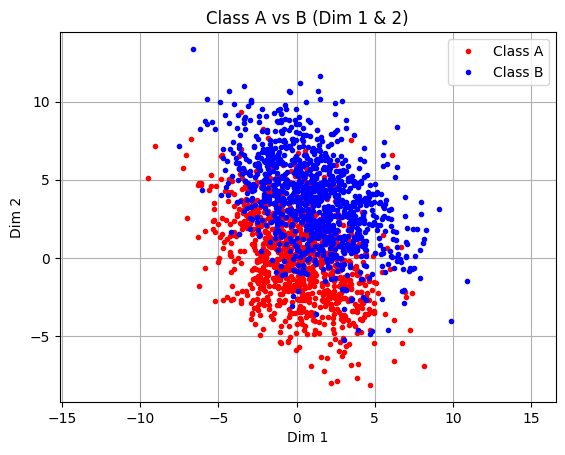

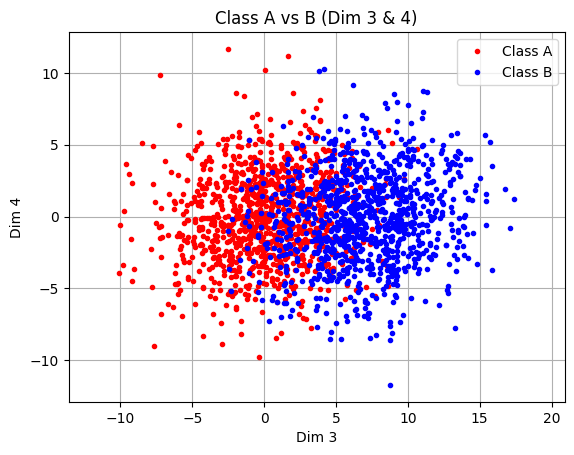


Evaluating All Feature Subsets
Subset  1: Features [1 0 0 0] → Accuracy = 0.5855
Subset  2: Features [0 1 0 0] → Accuracy = 0.7330
Subset  3: Features [1 1 0 0] → Accuracy = 0.8065
Subset  4: Features [0 0 1 0] → Accuracy = 0.8410
Subset  5: Features [1 0 1 0] → Accuracy = 0.8585
Subset  6: Features [0 1 1 0] → Accuracy = 0.8730
Subset  7: Features [1 1 1 0] → Accuracy = 0.9015
Subset  8: Features [0 0 0 1] → Accuracy = 0.4990
Subset  9: Features [1 0 0 1] → Accuracy = 0.5840
Subset 10: Features [0 1 0 1] → Accuracy = 0.7410
Subset 11: Features [1 1 0 1] → Accuracy = 0.8075
Subset 12: Features [0 0 1 1] → Accuracy = 0.8410
Subset 13: Features [1 0 1 1] → Accuracy = 0.8580
Subset 14: Features [0 1 1 1] → Accuracy = 0.8655
Subset 15: Features [1 1 1 1] → Accuracy = 0.9040


In [14]:
print("Synthetic Binary Classification with Sparse Modeling")

# generate default data
data, labels, class_a, class_b = generate_data(seed=42)

# plot dimension 1 vs 2
plot_data(class_a, class_b, dims=(0, 1), title="Class A vs B (Dim 1 & 2)", fname='1_2.pdf')

# plot dimension 3 vs 4
plot_data(class_a, class_b, dims=(2, 3), title="Class A vs B (Dim 3 & 4)", fname='3_4.pdf')

# gen all valid feature subsets
n_features = data.shape[1]
indicators = generate_indicators(n_features)


print("\nEvaluating All Feature Subsets")
scores = evaluate_sparse_models(data, labels, indicators)

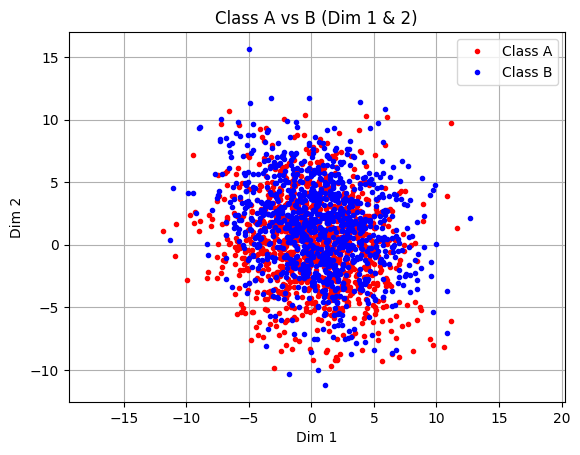

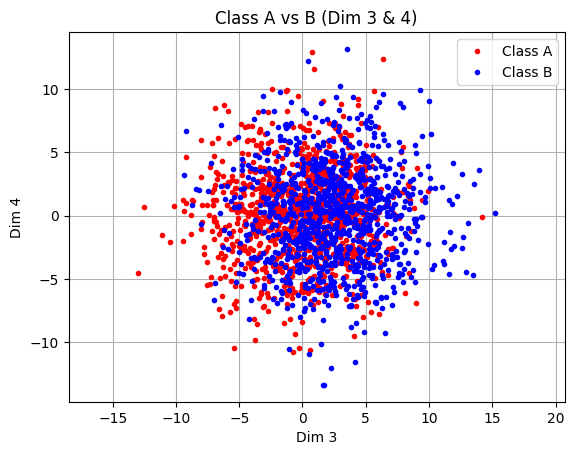


Evaluating All Feature Subsets
Subset  1: Features [1 0 0 0] → Accuracy = 0.5240
Subset  2: Features [0 1 0 0] → Accuracy = 0.5675
Subset  3: Features [1 1 0 0] → Accuracy = 0.5840
Subset  4: Features [0 0 1 0] → Accuracy = 0.6280
Subset  5: Features [1 0 1 0] → Accuracy = 0.6320
Subset  6: Features [0 1 1 0] → Accuracy = 0.6390
Subset  7: Features [1 1 1 0] → Accuracy = 0.6435
Subset  8: Features [0 0 0 1] → Accuracy = 0.4820
Subset  9: Features [1 0 0 1] → Accuracy = 0.5180
Subset 10: Features [0 1 0 1] → Accuracy = 0.5680
Subset 11: Features [1 1 0 1] → Accuracy = 0.5820
Subset 12: Features [0 0 1 1] → Accuracy = 0.6250
Subset 13: Features [1 0 1 1] → Accuracy = 0.6280
Subset 14: Features [0 1 1 1] → Accuracy = 0.6375
Subset 15: Features [1 1 1 1] → Accuracy = 0.6445


In [15]:
# generate more difficult data
hard_cov = np.array([
    [5, -2, 0, 0],
    [-2, 5, 0, 0],
    [0, 0, 5, 0],
    [0, 0, 0, 5]
])

data, labels, class_a, class_b = generate_data(
    n_samples=1000,
    n_features=4,
    noise_std=3,  # more noise
    mean_a=[0, 0, 0, 0],
    mean_b=[0.5, 1.5, 2.5, 0],  # class means are closer
    cov=hard_cov,
    seed=42
)

# plot dimension 1 vs 2
plot_data(class_a, class_b, dims=(0, 1), title="Class A vs B (Dim 1 & 2)")

# plot dimension 3 vs 4
plot_data(class_a, class_b, dims=(2, 3), title="Class A vs B (Dim 3 & 4)")

# gen all valid feature subsets
n_features = data.shape[1]
indicators = generate_indicators(n_features)


print("\nEvaluating All Feature Subsets")
scores = evaluate_sparse_models(data, labels, indicators)


[LogReg] Sparse Modeling with Default Data


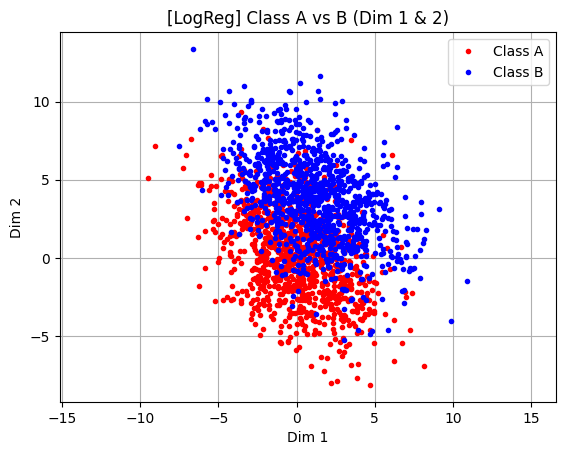

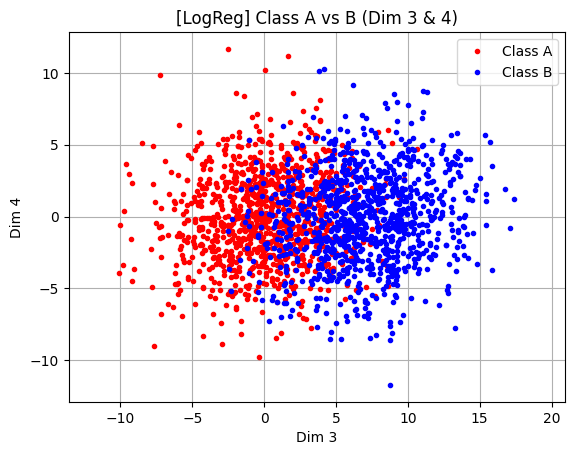

[LR] Subset  1: Features [1 0 0 0] → Accuracy = 0.5850
[LR] Subset  2: Features [0 1 0 0] → Accuracy = 0.7335
[LR] Subset  3: Features [1 1 0 0] → Accuracy = 0.8060
[LR] Subset  4: Features [0 0 1 0] → Accuracy = 0.8405
[LR] Subset  5: Features [1 0 1 0] → Accuracy = 0.8570
[LR] Subset  6: Features [0 1 1 0] → Accuracy = 0.8735
[LR] Subset  7: Features [1 1 1 0] → Accuracy = 0.9010
[LR] Subset  8: Features [0 0 0 1] → Accuracy = 0.4990
[LR] Subset  9: Features [1 0 0 1] → Accuracy = 0.5840
[LR] Subset 10: Features [0 1 0 1] → Accuracy = 0.7405
[LR] Subset 11: Features [1 1 0 1] → Accuracy = 0.8080
[LR] Subset 12: Features [0 0 1 1] → Accuracy = 0.8405
[LR] Subset 13: Features [1 0 1 1] → Accuracy = 0.8590
[LR] Subset 14: Features [0 1 1 1] → Accuracy = 0.8650
[LR] Subset 15: Features [1 1 1 1] → Accuracy = 0.9035

[LogReg] Sparse Modeling with HARDER Data


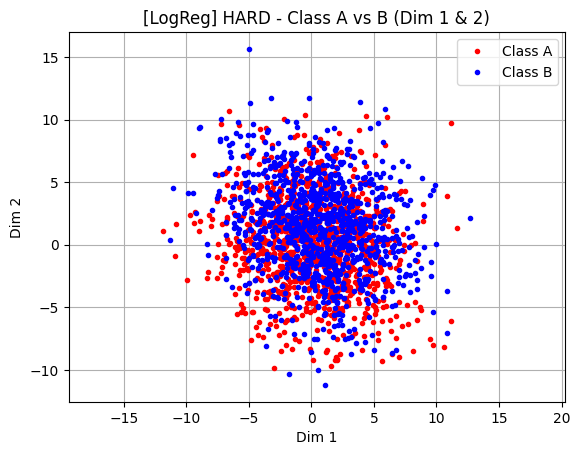

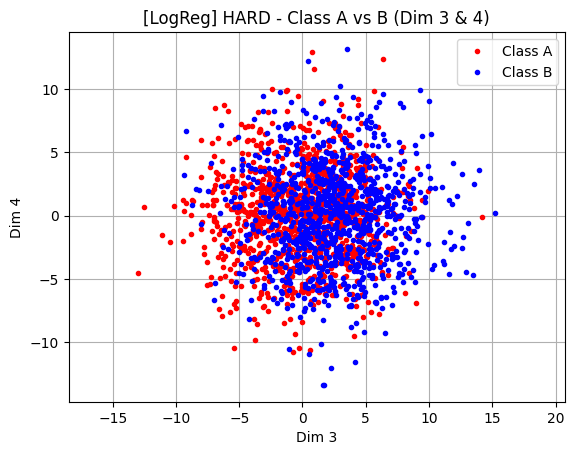

[LR] Subset  1: Features [1 0 0 0] → Accuracy = 0.5240
[LR] Subset  2: Features [0 1 0 0] → Accuracy = 0.5680
[LR] Subset  3: Features [1 1 0 0] → Accuracy = 0.5850
[LR] Subset  4: Features [0 0 1 0] → Accuracy = 0.6280
[LR] Subset  5: Features [1 0 1 0] → Accuracy = 0.6320
[LR] Subset  6: Features [0 1 1 0] → Accuracy = 0.6395
[LR] Subset  7: Features [1 1 1 0] → Accuracy = 0.6440
[LR] Subset  8: Features [0 0 0 1] → Accuracy = 0.4820
[LR] Subset  9: Features [1 0 0 1] → Accuracy = 0.5180
[LR] Subset 10: Features [0 1 0 1] → Accuracy = 0.5690
[LR] Subset 11: Features [1 1 0 1] → Accuracy = 0.5825
[LR] Subset 12: Features [0 0 1 1] → Accuracy = 0.6235
[LR] Subset 13: Features [1 0 1 1] → Accuracy = 0.6285
[LR] Subset 14: Features [0 1 1 1] → Accuracy = 0.6380
[LR] Subset 15: Features [1 1 1 1] → Accuracy = 0.6440


In [16]:
from sklearn.linear_model import LogisticRegression

def evaluate_sparse_models_logistic(data, labels, indicators, n_splits=10):
    '''
        Evaluate each feature subset using logistic regression and cross-validation.
    '''
    scores = {"mean": [], "std": []}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=1000)

    labels = labels.flatten()
    data_norm = preprocessing.StandardScaler().fit_transform(data)

    for idx, mask in enumerate(indicators):
        subset_scores = []
        for train_idx, test_idx in skf.split(data_norm, labels):
            X_train = data_norm[train_idx][:, mask == 1]
            X_test = data_norm[test_idx][:, mask == 1]
            y_train = labels[train_idx]
            y_test = labels[test_idx]

            if X_train.ndim == 1:
                X_train = X_train[:, np.newaxis]
                X_test = X_test[:, np.newaxis]

            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            score = metrics.accuracy_score(y_test, preds)
            subset_scores.append(score)

        scores["mean"].append(np.mean(subset_scores))
        scores["std"].append(np.std(subset_scores))
        print(f"[LR] Subset {idx+1:2d}: Features {mask} → Accuracy = {scores['mean'][-1]:.4f}")

    return scores

# experiment with default data
print("\n[LogReg] Sparse Modeling with Default Data")

# gen default synthetic data
data, labels, class_a, class_b = generate_data(seed=42)

# plot class distributions
plot_data(class_a, class_b, dims=(0, 1), title="[LogReg] Class A vs B (Dim 1 & 2)")
plot_data(class_a, class_b, dims=(2, 3), title="[LogReg] Class A vs B (Dim 3 & 4)")

# gen feature subset indicators
n_features = data.shape[1]
indicators = generate_indicators(n_features)

# eval logistic regression with sparse modeling
lr_scores_default = evaluate_sparse_models_logistic(data, labels, indicators)

# experiment with harder data
print("\n[LogReg] Sparse Modeling with HARDER Data")

# define more challenging covariance
hard_cov = np.array([
    [5, -2, 0, 0],
    [-2, 5, 0, 0],
    [0, 0, 5, 0],
    [0, 0, 0, 5]
])

# gen difficult dataset
data_hard, labels_hard, class_a_hard, class_b_hard = generate_data(
    n_samples=1000,
    n_features=4,
    noise_std=3,
    mean_a=[0, 0, 0, 0],
    mean_b=[0.5, 1.5, 2.5, 0],
    cov=hard_cov,
    seed=42
)

# plot harder data
plot_data(class_a_hard, class_b_hard, dims=(0, 1), title="[LogReg] HARD - Class A vs B (Dim 1 & 2)", fname='hard1_2.pdf')
plot_data(class_a_hard, class_b_hard, dims=(2, 3), title="[LogReg] HARD - Class A vs B (Dim 3 & 4)", fname='hard3_4.pdf')

# reuse same indicator set
lr_scores_hard = evaluate_sparse_models_logistic(data_hard, labels_hard, indicators)
